# 02 - GPCR Label Extraction

**Goal**: Query UniProt API to extract subfamily labels for classification

**Steps**:
1. Load parsed sequences
2. Clean data (remove zero-length, extreme outliers)
3. Query UniProt API for subfamily information
4. Extract and standardize labels
5. Save labeled dataset

In [1]:
import sys
sys.path.append('..')  # Add parent directory to path

import pandas as pd
import numpy as np
import requests
import time
from pathlib import Path
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports successful!")

✅ Imports successful!


## Step 1: Load Parsed Sequences

In [2]:
# Load the parsed data
input_path = Path('../data/processed/sequences_parsed.csv')
df = pd.read_csv(input_path)

print(f"📁 Loaded {len(df)} sequences")
print(f"📊 Columns: {list(df.columns)}")
df.head()

📁 Loaded 2000 sequences
📊 Columns: ['id', 'uniref_id', 'full_header', 'sequence', 'length', 'gap_count', 'gap_percentage', 'has_DRY', 'has_NPxxY']


,id,uniref_id,full_header,sequence,length,gap_count,gap_percentage,has_DRY,has_NPxxY
0,P07550,P07550,P07550,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,413,0,0.0,True,True
1,UniRef100_A0A8D2HM49,A0A8D2HM49,UniRef100_A0A8D2HM49\t434\t0.920\t2.021E-131\t...,MGQPGNSSDFLLASNGSHAPDHNVTQERDEAWVVGMAIVMSLIVLA...,416,0,0.0,True,True
2,UniRef100_A0A250YHJ2,A0A250YHJ2,UniRef100_A0A250YHJ2\t430\t0.889\t4.668E-130\t...,MGQPGNDSDFLLAPNGSQAPGHDITQERDEAWVVGMAMVMSLIVLA...,418,0,0.0,True,True
3,UniRef100_UPI0000E2F3F2,UPI0000E2F3F2,UniRef100_UPI0000E2F3F2\t427\t0.902\t5.752E-12...,MGQPGNGSDFLLAPNGSHAPDHDISQETDEAWVVGLAIVMSLIVLA...,420,0,0.0,True,True
4,UniRef100_UPI00189D415B,UPI00189D415B,UniRef100_UPI00189D415B\t426\t0.894\t7.873E-12...,MGQPGNNSVFLLAPNGSHEPDHNVTQERDEAWVVGMGIVMSFIVLA...,418,0,0.0,True,True


## Step 2: Data Cleaning

In [3]:
print("🧹 Data Cleaning")
print("=" * 50)

# Initial stats
print(f"Initial sequences: {len(df)}")

# 1. Remove zero-length sequences
df_clean = df[df['length'] > 0].copy()
print(f"After removing zero-length: {len(df_clean)} ({len(df) - len(df_clean)} removed)")

# 2. Remove extreme lengths (fragments and outliers)
df_clean = df_clean[(df_clean['length'] >= 250) & (df_clean['length'] <= 600)]
print(f"After length filter (250-600 aa): {len(df_clean)}")

# 3. Remove highly gapped sequences
df_clean = df_clean[df_clean['gap_percentage'] < 60]
print(f"After gap filter (<60%): {len(df_clean)}")

# 4. Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['sequence'])
print(f"After removing duplicates: {len(df_clean)}")

print("=" * 50)
print(f"✅ Final clean dataset: {len(df_clean)} sequences ({100*len(df_clean)/len(df):.1f}% retained)")

# Reset index
df_clean = df_clean.reset_index(drop=True)

🧹 Data Cleaning
Initial sequences: 2000
After removing zero-length: 1999 (1 removed)
After length filter (250-600 aa): 1999
After gap filter (<60%): 1999
After removing duplicates: 1998
✅ Final clean dataset: 1998 sequences (99.9% retained)


## Step 3: UniProt API Query Functions

In [4]:
def extract_uniprot_id(uniref_id):
    """
    Extract UniProt ID from UniRef ID
    Examples:
    - 'P07550' -> 'P07550'
    - 'UniRef100_A0A8D2HM49' -> 'A0A8D2HM49'
    - 'UPI0000E2F3F2' -> 'UPI0000E2F3F2'
    """
    if uniref_id.startswith('UniRef'):
        return uniref_id.split('_')[1]
    return uniref_id

def query_uniprot(uniprot_id, retries=3):
    """
    Query UniProt API for protein information
    Returns protein name, gene name, and organism
    """
    base_url = "https://rest.uniprot.org/uniprotkb"
    
    for attempt in range(retries):
        try:
            # Query UniProt
            response = requests.get(
                f"{base_url}/{uniprot_id}.json",
                timeout=10
            )
            
            if response.status_code == 200:
                data = response.json()
                
                # Extract protein name
                protein_name = data.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'Unknown')
                
                # Extract gene name
                gene_name = 'Unknown'
                if 'genes' in data and len(data['genes']) > 0:
                    gene_name = data['genes'][0].get('geneName', {}).get('value', 'Unknown')
                
                # Extract organism
                organism = data.get('organism', {}).get('scientificName', 'Unknown')
                
                return {
                    'protein_name': protein_name,
                    'gene_name': gene_name,
                    'organism': organism,
                    'status': 'success'
                }
            
            elif response.status_code == 404:
                return {'protein_name': 'Not found', 'gene_name': 'Not found', 
                        'organism': 'Not found', 'status': 'not_found'}
            
            else:
                time.sleep(1)  # Wait before retry
                
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(2)
            else:
                return {'protein_name': 'Error', 'gene_name': 'Error', 
                        'organism': 'Error', 'status': f'error: {str(e)}'}
    
    return {'protein_name': 'Error', 'gene_name': 'Error', 
            'organism': 'Error', 'status': 'timeout'}

def extract_gpcr_subfamily(protein_name, gene_name):
    """
    Extract GPCR subfamily from protein/gene name
    
    Common patterns:
    - Adrenergic receptors: ADRB1, ADRB2, ADRA1A, etc.
    - Dopamine receptors: DRD1, DRD2, etc.
    - Serotonin receptors: 5-HT1A, HTR1A, etc.
    - Muscarinic receptors: CHRM1, CHRM2, etc.
    """
    combined = f"{protein_name} {gene_name}".upper()
    
    # Adrenergic receptors
    if any(x in combined for x in ['ADRENERGIC', 'ADRB', 'ADRA', 'ADREN']):
        if 'BETA' in combined or 'ADRB' in combined:
            return 'Adrenergic_beta'
        elif 'ALPHA' in combined or 'ADRA' in combined:
            return 'Adrenergic_alpha'
        return 'Adrenergic'
    
    # Dopamine receptors
    if any(x in combined for x in ['DOPAMINE', 'DRD', 'D1R', 'D2R', 'D3R', 'D4R', 'D5R']):
        return 'Dopamine'
    
    # Serotonin receptors
    if any(x in combined for x in ['SEROTONIN', '5-HT', 'HTR', '5HT']):
        return 'Serotonin'
    
    # Muscarinic receptors
    if any(x in combined for x in ['MUSCARINIC', 'CHRM', 'CHOLINERGIC']):
        return 'Muscarinic'
    
    # Histamine receptors
    if any(x in combined for x in ['HISTAMINE', 'HRH']):
        return 'Histamine'
    
    # Adenosine receptors
    if any(x in combined for x in ['ADENOSINE', 'ADORA']):
        return 'Adenosine'
    
    # Opiate/Opioid receptors
    if any(x in combined for x in ['OPIOID', 'OPIATE', 'OPRM', 'OPRK', 'OPRD']):
        return 'Opioid'
    
    # Chemokine receptors
    if any(x in combined for x in ['CHEMOKINE', 'CXCR', 'CCR']):
        return 'Chemokine'
    
    # Cannabinoid receptors
    if any(x in combined for x in ['CANNABINOID', 'CNR']):
        return 'Cannabinoid'
    
    # Rhodopsin (visual)
    if any(x in combined for x in ['RHODOPSIN', 'OPSIN', 'RHO']):
        return 'Rhodopsin'
    
    # Orphan/Unknown
    return 'Other_ClassA'

print("✅ UniProt query functions defined")

✅ UniProt query functions defined


## Step 4: Query UniProt for All Sequences

⚠️ **Note**: This will take ~10-30 minutes for 2000 sequences due to API rate limits

In [5]:
# Extract UniProt IDs
df_clean['uniprot_id'] = df_clean['uniref_id'].apply(extract_uniprot_id)

# Initialize columns
df_clean['protein_name'] = ''
df_clean['gene_name'] = ''
df_clean['organism'] = ''
df_clean['query_status'] = ''
df_clean['subfamily'] = ''

# Query UniProt with progress bar
print("🔍 Querying UniProt API...")
print("⏱️  This may take 10-30 minutes. Progress will be saved every 100 queries.")

for idx, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Querying UniProt"):
    # Query UniProt
    result = query_uniprot(row['uniprot_id'])
    
    # Store results
    df_clean.at[idx, 'protein_name'] = result['protein_name']
    df_clean.at[idx, 'gene_name'] = result['gene_name']
    df_clean.at[idx, 'organism'] = result['organism']
    df_clean.at[idx, 'query_status'] = result['status']
    
    # Extract subfamily
    subfamily = extract_gpcr_subfamily(result['protein_name'], result['gene_name'])
    df_clean.at[idx, 'subfamily'] = subfamily
    
    # Rate limiting: 1 request per second (conservative)
    time.sleep(1)
    
    # Save intermediate results every 100 queries
    if (idx + 1) % 100 == 0:
        temp_path = Path('../data/processed/sequences_labeled_temp.csv')
        temp_path.parent.mkdir(parents=True, exist_ok=True)
        df_clean.to_csv(temp_path, index=False)
        print(f"\n💾 Progress saved: {idx+1}/{len(df_clean)} sequences")

print("✅ UniProt query complete!")

🔍 Querying UniProt API...
⏱️  This may take 10-30 minutes. Progress will be saved every 100 queries.


Querying UniProt:   5%|▌         | 100/1998 [05:20<1:28:13,  2.79s/it]


💾 Progress saved: 100/1998 sequences


Querying UniProt:  10%|█         | 200/1998 [11:25<1:50:06,  3.67s/it]


💾 Progress saved: 200/1998 sequences


Querying UniProt:  15%|█▌        | 300/1998 [16:45<1:33:24,  3.30s/it]


💾 Progress saved: 300/1998 sequences


Querying UniProt:  20%|██        | 400/1998 [21:47<1:06:10,  2.48s/it]


💾 Progress saved: 400/1998 sequences


Querying UniProt:  25%|██▌       | 500/1998 [27:11<1:34:09,  3.77s/it]


💾 Progress saved: 500/1998 sequences


Querying UniProt:  30%|███       | 600/1998 [33:14<1:30:49,  3.90s/it]


💾 Progress saved: 600/1998 sequences


Querying UniProt:  35%|███▌      | 700/1998 [39:55<1:21:15,  3.76s/it]


💾 Progress saved: 700/1998 sequences


Querying UniProt:  40%|████      | 800/1998 [46:24<1:02:03,  3.11s/it]


💾 Progress saved: 800/1998 sequences


Querying UniProt:  45%|████▌     | 900/1998 [52:26<47:27,  2.59s/it]  


💾 Progress saved: 900/1998 sequences


Querying UniProt:  50%|█████     | 1000/1998 [57:46<52:10,  3.14s/it] 


💾 Progress saved: 1000/1998 sequences


Querying UniProt:  55%|█████▌    | 1100/1998 [1:03:28<49:24,  3.30s/it]  


💾 Progress saved: 1100/1998 sequences


Querying UniProt:  60%|██████    | 1200/1998 [1:09:33<56:15,  4.23s/it]  


💾 Progress saved: 1200/1998 sequences


Querying UniProt:  65%|██████▌   | 1300/1998 [1:15:08<32:10,  2.77s/it]  


💾 Progress saved: 1300/1998 sequences


Querying UniProt:  70%|███████   | 1400/1998 [1:21:30<35:22,  3.55s/it]


💾 Progress saved: 1400/1998 sequences


Querying UniProt:  75%|███████▌  | 1500/1998 [1:27:52<32:02,  3.86s/it]


💾 Progress saved: 1500/1998 sequences


Querying UniProt:  80%|████████  | 1600/1998 [1:33:35<15:29,  2.34s/it]


💾 Progress saved: 1600/1998 sequences


Querying UniProt:  85%|████████▌ | 1700/1998 [1:39:17<18:10,  3.66s/it]


💾 Progress saved: 1700/1998 sequences


Querying UniProt:  90%|█████████ | 1800/1998 [1:45:25<10:12,  3.09s/it]


💾 Progress saved: 1800/1998 sequences


Querying UniProt:  95%|█████████▌| 1900/1998 [1:50:48<05:52,  3.60s/it]


💾 Progress saved: 1900/1998 sequences


Querying UniProt: 100%|██████████| 1998/1998 [1:57:00<00:00,  3.51s/it]

✅ UniProt query complete!


## Step 5: Analyze Label Distribution

In [6]:
# Check query success rate
status_counts = df_clean['query_status'].value_counts()
print("📊 Query Status:")
print(status_counts)
print(f"\n✅ Success rate: {100*status_counts.get('success', 0)/len(df_clean):.1f}%")

# Check subfamily distribution
print("\n" + "="*50)
print("📊 Subfamily Distribution:")
print("="*50)
subfamily_counts = df_clean['subfamily'].value_counts()
for subfamily, count in subfamily_counts.items():
    print(f"{subfamily:20s}: {count:4d} ({100*count/len(df_clean):5.1f}%)")

📊 Query Status:
query_status
success    1090
timeout     908
Name: count, dtype: int64

✅ Success rate: 54.6%

📊 Subfamily Distribution:
Other_ClassA        : 1483 ( 74.2%)
Adrenergic_beta     :  372 ( 18.6%)
Adrenergic_alpha    :   53 (  2.7%)
Dopamine            :   35 (  1.8%)
Histamine           :   31 (  1.6%)
Serotonin           :   23 (  1.2%)
Muscarinic          :    1 (  0.1%)


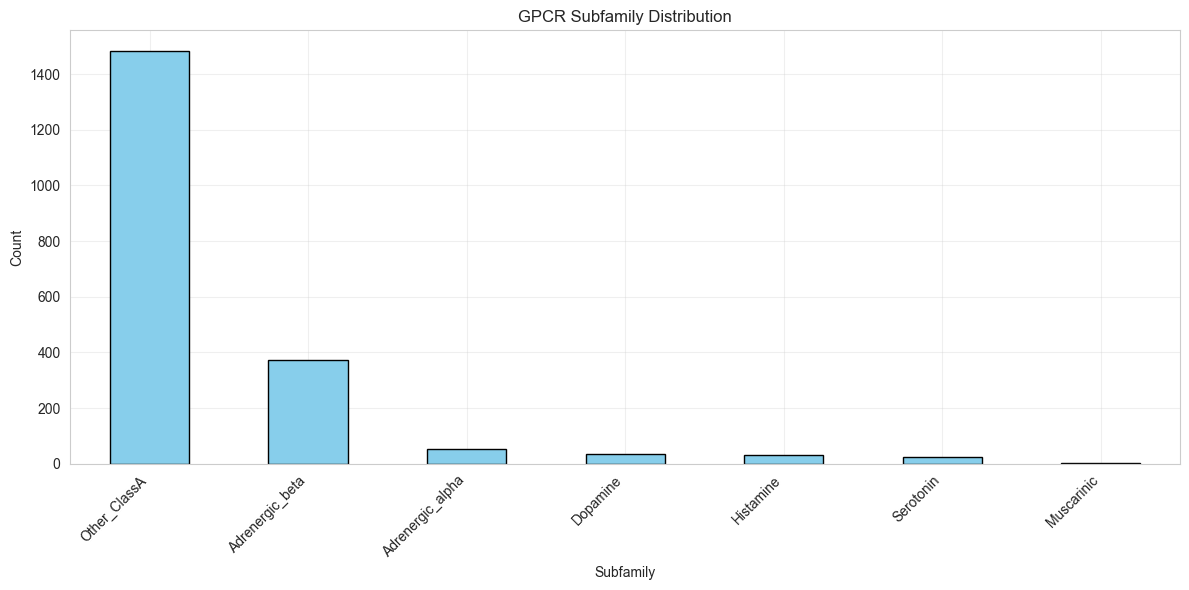

In [7]:
# Visualize distribution
fig, ax = plt.subplots(figsize=(12, 6))
subfamily_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Subfamily')
ax.set_ylabel('Count')
ax.set_title('GPCR Subfamily Distribution')
ax.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
fig_path = Path('../results/figures/subfamily_distribution.png')
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

## Step 6: Filter for Classification Task

For Task 1, we need subfamilies with enough examples (≥50 sequences)

In [8]:
# Minimum sequences per subfamily for classification
MIN_SEQUENCES = 50

# Count sequences per subfamily
subfamily_counts = df_clean['subfamily'].value_counts()

# Keep subfamilies with enough examples
valid_subfamilies = subfamily_counts[subfamily_counts >= MIN_SEQUENCES].index.tolist()

df_labeled = df_clean[df_clean['subfamily'].isin(valid_subfamilies)].copy()

print(f"📊 Classification Dataset:")
print(f"   Subfamilies with ≥{MIN_SEQUENCES} sequences: {len(valid_subfamilies)}")
print(f"   Total sequences: {len(df_labeled)}")
print(f"   Retention rate: {100*len(df_labeled)/len(df_clean):.1f}%")

print("\n✅ Final subfamilies:")
for subfamily in valid_subfamilies:
    count = len(df_labeled[df_labeled['subfamily'] == subfamily])
    print(f"   {subfamily:20s}: {count:4d} sequences")

📊 Classification Dataset:
   Subfamilies with ≥50 sequences: 3
   Total sequences: 1908
   Retention rate: 95.5%

✅ Final subfamilies:
   Other_ClassA        : 1483 sequences
   Adrenergic_beta     :  372 sequences
   Adrenergic_alpha    :   53 sequences


## Step 7: Save Labeled Dataset

In [9]:
# Save full dataset (all queries)
output_path_full = Path('../data/processed/sequences_labeled_full.csv')
output_path_full.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_csv(output_path_full, index=False)
print(f"💾 Saved full dataset: {output_path_full}")
print(f"   {len(df_clean)} sequences")

# Save classification dataset (filtered)
output_path_class = Path('../data/processed/sequences_labeled_classification.csv')
df_labeled.to_csv(output_path_class, index=False)
print(f"💾 Saved classification dataset: {output_path_class}")
print(f"   {len(df_labeled)} sequences")
print(f"   {len(valid_subfamilies)} subfamilies")

# Save summary statistics
summary = {
    'total_sequences': len(df_clean),
    'classification_sequences': len(df_labeled),
    'num_subfamilies': len(valid_subfamilies),
    'subfamilies': valid_subfamilies,
    'min_sequences_per_class': MIN_SEQUENCES
}

summary_path = Path('../data/processed/labeling_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"💾 Saved summary: {summary_path}")

print("\n" + "="*50)
print("✅ Phase 2 Complete: Label Extraction")
print("="*50)
print(f"📊 Ready for Task 1: Classification")
print(f"   Training set: {len(df_labeled)} sequences")
print(f"   Classes: {len(valid_subfamilies)} subfamilies")
print(f"\n📁 Next: Create 03_model_training.ipynb")

💾 Saved full dataset: ..\data\processed\sequences_labeled_full.csv
   1998 sequences
💾 Saved classification dataset: ..\data\processed\sequences_labeled_classification.csv
   1908 sequences
   3 subfamilies
💾 Saved summary: ..\data\processed\labeling_summary.json

✅ Phase 2 Complete: Label Extraction
📊 Ready for Task 1: Classification
   Training set: 1908 sequences
   Classes: 3 subfamilies

📁 Next: Create 03_model_training.ipynb
